In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, newton
import emcee
import corner

import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
emcee.__version__

'3.0rc2'

#   Multi-Dimensional Integration with MCMC

-----

By Megan Bedell (Flatiron Institute)

10 September 2019

### Problem 1: Fitting a Sinusoid to Data

In this example, we will download a time series of radial velocities for the star HD209458. This star hosts a Hot Jupiter exoplanet. In fact, [this planet](https://en.wikipedia.org/wiki/HD_209458_b) was the first to be seen in transit and was discovered 20 years ago yesterday!

Because the eccentricity is low for this planet, we can fit its orbit in the radial velocities with a relatively simple model: a sinusoid.

Below is a snippet of code that will download the time-series data from [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/):

In [2]:
datafile = 'https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0108/0108859/data/UID_0108859_RVC_001.tbl'
data = pd.read_fwf(datafile, header=0, names=['t', 'rv', 'rv_err'], skiprows=22)
data['t'] -= data['t'][0]

#### Problem 1a
Plot the data. Let's take a look at what we're working with!

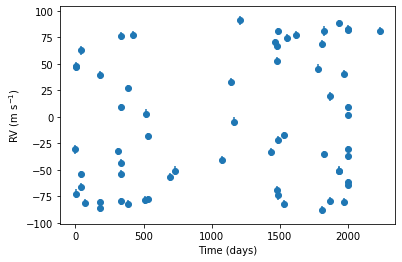

In [3]:
fig, ax = plt.subplots()
ax.errorbar(data['t'], data['rv'], yerr=data['rv_err'], fmt='o')
ax.set_xlabel('Time (days)')
ax.set_ylabel(r'RV (m s$^{-1}$)');

#### Problem 1b

Write the sinusoid function that we want to fit and get ready to run MCMC with helper functions.

First let's write a "get_model_predictions" function - this will resemble yesterday's same-named function, but instead of returning a line it should return a sinusoid. I suggest using the following free parameters, although there are a few alternative options that you may use instead:



```
theta = [p, # period of the sinusoid
         a, # semi-amplitude of the sinusoid
         t0, # reference x at which sine phase = 0
         rv0] # constant offset in y
```

The RV prediction is then:
$$RV(t) = a \sin\Big(\frac{2\pi}{p} (t - t_0)\Big) + rv_0$$


In [15]:
def get_model_predictions(theta, t):
  '''
  Calculate RV predictions for parameters theta and timestamps t.
  '''
  period, amplitude, t0, rv0 = theta
  model_preds = amplitude * np.sin(2*np.pi *(t-t0)/period) + rv0
  return model_preds

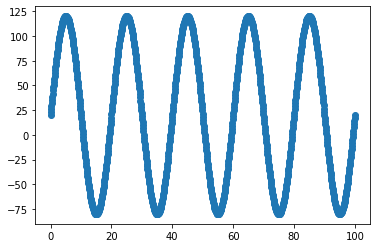

In [56]:
t = np.linspace(0, 100,1000)
plt.scatter(t, get_model_predictions((20, 100, 0, 20),t))

Write a lnprior function with flat priors on all parameters - again, this will be similar to yesterday's function, but with different values.

*Hint: some of the bounds on these parameters will be physically motivated (i.e. orbital period cannot be negative). For others, you'll need to guess something reasonable but generous - i.e., a Hot Jupiter planet probably does not have an orbital period above a year or so.*

In [80]:
def lnprior(theta):
    period, amplitude, t0, rv0 = theta
    if (0 < period <= 400) and (0 < amplitude <= 200) and (0 < t0 <= 500) and (-100 < rv0 <= 100):
        lnp = np.log(1./400) + np.log(1./200) + np.log(1/500) + np.log(1/200.)
    else:
        return -np.inf  
    return lnp

The following functions can be reused as-is from the previous day's Metropolis-Hastings exercise, so just copy-and-paste or import them:

lnlikelihood, lnposterior, hastings_ratio, propose_jump, mh_mcmc



In [81]:
def lnlikelihood(theta, y, x, y_unc):
    model_preds = get_model_predictions(theta, x)
    
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl
  

def lnposterior(theta, y, x, y_unc):
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc)
    lnpost = lnl + lnp
        
    return lnpost

def hastings_ratio(theta_1, theta_0, y, x, y_unc):
    lnpost1 = lnposterior(theta_1, y, x, y_unc)
    lnpost0 = lnposterior(theta_0, y, x, y_unc)
    
    h_ratio = np.exp(lnpost1 - lnpost0)
    
    return h_ratio
  

def propose_jump(theta, cov):
    if np.shape(theta) == np.shape(cov):
        cov = np.diag(np.array(cov)**2)
    
    proposed_position = np.random.multivariate_normal(theta, cov)
    
    return proposed_position
  
def mh_mcmc(theta_0, cov, nsteps, y, x, y_unc):
    
    positions = np.zeros((nsteps+1, len(theta_0)))
    lnpost_at_pos = -np.inf*np.ones(nsteps+1)
    acceptance_ratio = np.zeros_like(lnpost_at_pos)
    accepted = 0
    
    positions[0] = theta_0
    lnpost_at_pos[0] = lnposterior(theta_0, y, x, y_unc)
    
    for step_num in np.arange(1, nsteps+1):
        proposal = propose_jump(positions[step_num-1], cov)
        H = hastings_ratio(proposal, positions[step_num-1], y, x, y_unc)
        R = np.random.uniform()
        
        if H > R:
            accepted += 1
            positions[step_num] = proposal
            lnpost_at_pos[step_num] = lnposterior(proposal, y, x, y_unc)
            acceptance_ratio[step_num] = float(accepted)/step_num
        else:
            positions[step_num] = positions[step_num-1]
            lnpost_at_pos[step_num] = lnpost_at_pos[step_num-1]
            acceptance_ratio[step_num] = float(accepted)/step_num
    
    return (positions, lnpost_at_pos, acceptance_ratio)
 

#### Problem 1c

Run the MCMC.

Let's start with initialization values.

To save some time, I will assert that if we made a Lomb-Scargle periodogram of the RVs, there would be a peak near period = 3.53 days, so start with that guess and let's figure out what the best values might be for the other parameters.

(If you finish early and are up for a bonus problem, you can double-check my assertion using [astropy timeseries](https://docs.astropy.org/en/stable/timeseries/lombscargle.html)!)

In [82]:
theta_0 = [3.53, 100, 100, 10]

Now run the MCMC for 5000 steps. I'll give you (the diagonal of a) covariance matrix for the multi-dimensional Gaussian proposal function to start with. As you saw yesterday afternoon, this `cov` parameter sets the step sizes that the M-H algorithm will use when it proposes new values.

In [83]:
cov = [0.01, 70, 0.05, 0.01]
pos, lnpost, acc = mh_mcmc(theta_0, cov, 5000, data['rv'], data['t'], data['rv_err'])

In [84]:
pos.shape

(5001, 4)

Do a pairs plot for the first two parameters. Does the behavior of this chain seem efficient?

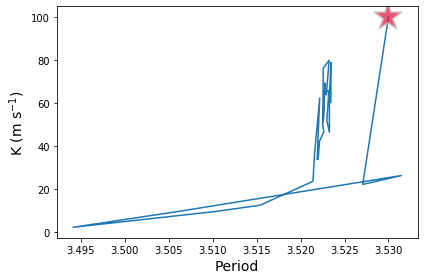

In [85]:
fig, ax = plt.subplots()
ax.plot(pos[:,0], pos[:,1])
ax.plot(theta_0[0], theta_0[1], '*', ms=30, 
        mfc='Crimson', mec='0.8', mew=2, 
        alpha=0.7)
ax.set_xlabel('Period', fontsize=14)
ax.set_ylabel(r'K (m s$^{-1}$)', fontsize=14)
fig.tight_layout()

#### Problem 1d

There were a couple of issues with the previous MCMC run. Let's start with this one: we started the chains running at a place that was not very close to the best-fit solution.

Find a better set of initialization values by optimizing *before* we run the MCMC.

We'll use scipy.optimize.minimize to get best-fit parameters. Remember that the lnlikelihood function needs to be *maximized* not *minimized*, so we'll need a new function that works the same way, but negative.

In [86]:
def nll(*par):
  return -lnlikelihood(*par)
  
res = minimize(nll, theta_0, 
               args=(data['rv'], data['t'], data['rv_err']),
               method='Powell')
print('Optimizer finished with message "{0}" and \n\
      best-fit parameters {1}'.format(res['message'], res['x']))

Optimizer finished with message "Optimization terminated successfully." and 
      best-fit parameters [ 3.52472393 84.29675555 98.90591494  0.13153625]


Plot the data points and your best-fit model. Does the fit look reasonable? (You may need to zoom into a small time range to tell.)

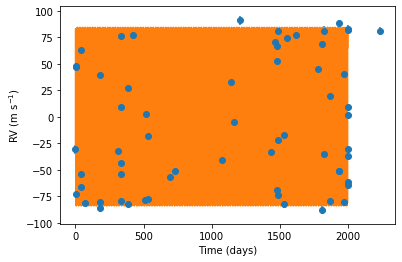

In [87]:
# complete
fig, ax = plt.subplots()
ax.errorbar(data['t'], data['rv'], yerr=data['rv_err'], fmt='o')
t_test = np.linspace(0,2000, 5000)
plt.plot(t_test, get_model_predictions(res['x'], t_test))
plt.xlabel('Time (days)')
plt.ylabel(r'RV (m s$^{-1}$)');

Another way to see if we're on the right track is to plot the data phased to the orbital period that we found. Do that and optionally overplot the phased model as well.

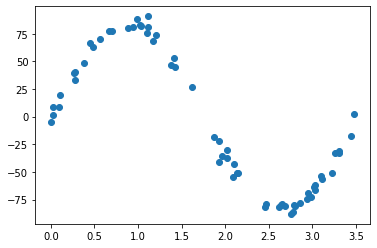

In [91]:
period, amplitude, t0, rv0 = res['x']

fig, ax = plt.subplots()
phased_t = (data['t'] - t0) % period
plt.scatter(phased_t, data['rv'])

Now re-run the MCMC using these parameters as the initial values and make another pairs plot. Again, I'm going to give you some step size parameters to start with. Because we're now initializing the chain close to the likelihood maximum, we don't want it to move too far away, so I've lowered the values of `cov`.

In [97]:
theta_bestfit = res['x']
cov = [0.001, 0.1, 0.01, 0.1]

pos, lnpost, acc = mh_mcmc(theta_bestfit, cov, 10000, data['rv'], data['t'], data['rv_err'])

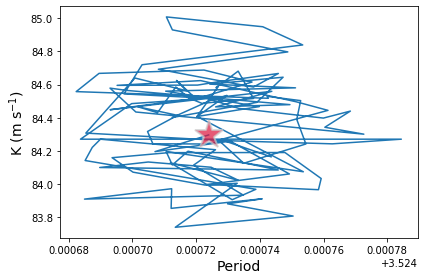

In [98]:
fig, ax = plt.subplots()
ax.plot(pos[:,0], pos[:,1])
ax.plot(theta_bestfit[0], theta_bestfit[1], '*', ms=30, 
        mfc='Crimson', mec='0.8', mew=2, 
        alpha=0.7)
ax.set_xlabel('Period', fontsize=14)
ax.set_ylabel(r'K (m s$^{-1}$)', fontsize=14)
fig.tight_layout()

#### Problem 1e

Now let's tackle another issues: chain efficiency. Calculate the auto-correlation length of your chain.

First, let's just plot the sequence of orbital period values in the chain in a trace plot. From eyeballing this sequence, about how many steps do you think are needed to reach a sample that is independent from the previous one(s)?

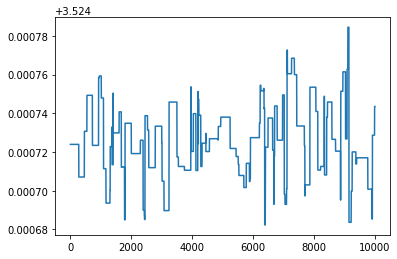

In [99]:
plt.plot(pos[:,0])

Writing an autocorrelation function for this purpose actually gets a bit tricky, so we'll use the built-in functionality of emcee.

For the documentation on these functions, check [the emcee user guide](https://emcee.readthedocs.io/en/latest/user/autocorr/).

For a more in-depth look at how this is calculated and why it's tricky, check out [this tutorial](https://emcee.readthedocs.io/en/latest/tutorials/autocorr/).

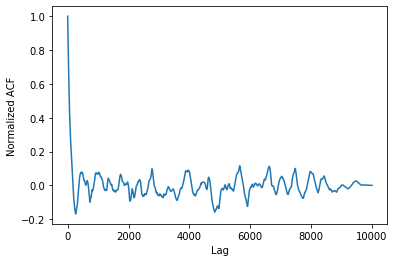

In [100]:
acf = emcee.autocorr.function_1d(pos[:,0])
plt.plot(acf)
plt.xlabel('Lag')
plt.ylabel('Normalized ACF');

In [101]:
act = emcee.autocorr.integrated_time(pos[:,0], quiet=True)
print('The integrated autocorrelation time is estimated as: {0}'.format(act))

The integrated autocorrelation time is estimated as: [110.2759628]


#### Problem 1f

Change the step size of the MCMC. What does this do to the auto-correlation length? Does this seem better or worse, and why?

In [102]:
cov = [0.0001, 0.1, 0.01, 0.1]
pos, lnpost, acc = mh_mcmc(theta_bestfit, cov, 10000, data['rv'], data['t'], data['rv_err'])

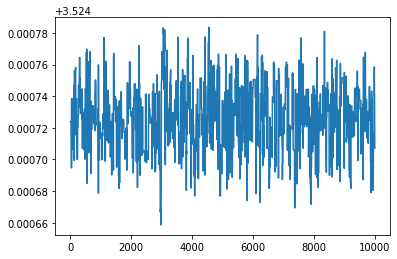

In [103]:
plt.plot(pos[:,0])

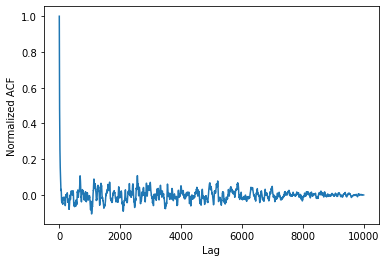

In [104]:
acf = emcee.autocorr.function_1d(pos[:,0])
plt.plot(acf)
plt.xlabel('Lag')
plt.ylabel('Normalized ACF');

In [105]:
act = emcee.autocorr.integrated_time(pos[:,0], quiet=True)
print('The integrated autocorrelation time is estimated as: {0}'.format(act))

The integrated autocorrelation time is estimated as: [26.07603308]


#### Problem 1g

Using the step sizes and starting conditions that you deem best, run your MCMC for *at least* 500x the auto-correlation length to get a large number of independent samples. Plot the posterior distribution of radial velocity semi-amplitude K. This parameter is arguably the most important output of an RV fit, because it is a measurement of the mass of the planet.

In [106]:
cov = [0.0001, 0.1, 0.01, 0.1]
pos, lnpost, acc = mh_mcmc(theta_bestfit, cov, 20000, data['rv'], data['t'], data['rv_err'])

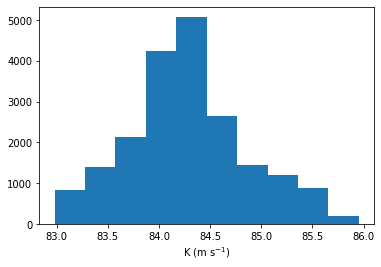

In [109]:
plt.hist(pos[:,1])
plt.xlabel(r'K (m s$^{-1}$)');

From these results, what can we say about the true value of K? What is the probability that K > 84 m/s? 85 m/s? 90 m/s? Are these numbers a reliable estimator of the true probability, in your opinion?

In [116]:
k = pos[:,1]
N = k.shape[0]
print('The probability that K > 84 m/s is: {0:.2f}'.format(np.sum(k>84)/N))
print('The probability that K > 85 m/s is: {0:.2f}'.format(np.sum(k>85)/N))
print('The probability that K > 90 m/s is: {0:.2f}'.format(np.sum(k>90)/N))

The probability that K > 84 m/s is: 0.71
The probability that K > 85 m/s is: 0.13
The probability that K > 90 m/s is: 0.00


#### Challenge Problem 1h

Try some different values of `cov[0]` (the step size for the orbital period). Make a plot of the acceptance fraction as a function of step size. Does this make sense?

#### Challenge Problem 1i

For different values of `cov[0]`, plot the correlation length. Does this make sense?

### Problem 2: Fitting a Keplerian to Data

In the previous example, the orbit we were fitting had negligible eccentricity, so we were able to fit it with a sinusoid. In this example, we'll look at the high-eccentricity planet HD 80606b and fit a full Keplerian model to its RV data. This requires introducing some new free parameters to the model, which as we will see are not always straightforward to sample!

In [ ]:
datafile = 'https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0045/0045982/data/UID_0045982_RVC_006.tbl'
data = pd.read_fwf(datafile, header=0, names=['t', 'rv', 'rv_err'], skiprows=21)
data['t'] -= data['t'][0]

#### Problem 2a

Again, let's start by plotting the data. Make plots of the time series and the time series phased to a period of 111.4 days.

In [ ]:
fig, ax = plt.subplots()
ax.errorbar( # complete
ax.set_xlabel('Time (days)')
ax.set_ylabel(r'RV (m s$^{-1}$)');

In [ ]:
# phased plot goes here

This planet's orbit should look pretty different from a sine wave!

#### Problem 2b

Remake the `get_model_predictions` and `lnprior` functions to fit a Keplerian.

Since this is a bit in the weeds of astronomy for the purposes of this workshop, I've gone ahead and written a solver for Kepler's equation and a `get_model_predictions` function that will deliver RVs for you. Read over the docstring and use the information given there to write a `lnprior` function for `theta`.

In [ ]:
def calc_ea(ma, ecc):
    # Kepler solver - calculates eccentric anomaly
    tolerance = 1e-3
    ea = np.copy(ma)
    while True:
        diff = ea - ecc * np.sin(ea) - ma
        ea -= diff / (1. - ecc * np.cos(ea))
        if abs(diff).all() <= tolerance:
            break
    return ea 
    
def get_model_predictions(theta, t):
    '''
    Calculate Keplerian orbital RVs
    
    Input
    -----
    theta : list
      A list of values for the following parameters:
       Orbital period,
       RV semi-amplitude,
       eccentricity (between 0-1),
       omega (argument of periastron; an angle in radians
              denoting the orbital phase where the planet
              passes closest to the host star)
       Tp (time of periastron; reference timestamp for the above)
       RV0 (constant RV offset)
    
    t : list or array
      Timestamps at which to calculate the RV
      
    Returns
    -------
    rvs : list or array
      Predicted RVs at the input times.
    '''
    P, K, ecc, omega, tp, rv0 = theta
    
    ma = 2. * np.pi / P * (t - tp)  # mean anomaly
    ea = calc_ea(ma, ecc)  # eccentric anomaly

    f = 2.0 * np.arctan2(np.sqrt(1+ecc)*np.sin(ea/2.0), 
                         np.sqrt(1-ecc)*np.cos(ea/2.0)) # true anomaly
    rvs = - K * (np.cos(omega + f) + ecc*np.cos(omega))
    return rvs + rv0

In [ ]:
def lnprior(theta):
    # complete

#### Problem 2c

Play around with the starting parameters until you're convinced that you have a reasonable fit.

In [ ]:
theta_0 = # complete

plt.errorbar(data['t'], data['rv'], data['rv_err'],
             fmt='o', ms=4)
xs = np.linspace(900, 1050, 1000)
plt.plot(xs, get_model_predictions(theta_0, xs), c='DarkOrange')
plt.xlim([900,1050])
plt.xlabel('Time (days)')
plt.ylabel(r'RV (m s$^{-1}$)');

#### Problem 2d

Run the MCMC for 1000 steps and plot a trace of the eccentricity parameter. How efficiently is it running?

Optional challenge: if you wrote a Gibbs sampler yesterday, use that instead of Metropolis-Hastings here!

In [ ]:
cov = [0.1, 100, 0.01, 0.1, 0.1, 100]

pos, lnpost, acc = mh_mcmc( # complete

In [ ]:
#complete 
plt.ylabel('Eccentricity')
plt.xlabel('Step');

#### Problem 2e

Make a corner plot of the results. Which parameters seem most correlated? Which are most and least well-constrained by the data?

In [ ]:
corner.corner( # complete

#### Problem 2f

Ford et al. (2006) suggest mitigating this issue by reparameterizing the orbital parameters $e$ and $\omega$ as $e cos\omega$ and $e sin\omega$. Modify the `get_model_predictions` and `lnprior` functions accordingly and rerun the MCMC. Does performance improve?

*Note: the efficiency of a basic MCMC in this situation is never going to be excellent. We'll talk more about challenging cases like this and how to deal with them in later lectures!*

In [ ]:
def get_model_predictions(theta, t):
    # complete
  
def lnprior(theta):
    # complete

In [ ]:
theta_0 = # complete
cov = # complete

pos, lnpost, acc = mh_mcmc( # complete

In [ ]:
# complete
plt.ylabel('ecosw')
plt.xlabel('Step');

In [ ]:
corner.corner( # complete